
### PROJECT TITLE - PREDICT THE EXPECTED ANSWER

### PROBLEM STATEMENT - To predict the associated intent for each questions realted to drugs.

#posos challenge

### Reviewing the Dataset
1. **input_test.csv** – This dataset contains IDs and Question.Each row represents one unique ID followed by Question.

2. **test_train.csv** – This dataset contains IDs and Question.Each row represents one unique ID followed by Question.
   
3. **train_output.csv** – This dataset contains IDs and Intention.Each row contains ID followed by Intention.

### Importing Libraries

In [42]:
import numpy as np
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB 
import re
import string
import enchant
import csv
import unidecode
from functools import partial
from scipy import sparse
import numpy as np
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve
import spacy
import fr_core_news_sm
from nltk.corpus import stopwords
from nltk.metrics import edit_distance
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/divya/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['save', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Reading the data

In [43]:
test_input = pd.read_csv('./input_test.fr.en.csv')
train_input = pd.read_csv('./input_train.fr.en.csv')
train_output = pd.read_csv('./challenge_output_data_training_file_predict_the_expected_answer.csv')

In [44]:
#sample train data
train_input.head()

,ID,question
0,0,"hello, I m was wrong forum for my question so ..."
1,1,is what the motilium relieve me against nausea?
2,2,my doctor prescribed adenyl. 2nd stamp of terr...
3,3,Is there a form adapted to the child of 5 year...
4,4,My doctor treats me to a rhino pharingite and ...


In [45]:
#Sample test data
test_input.head()

,ID,question
0,8028,homeopathy autism-vaccine-antidote ??
1,8029,What topically applied to atopic dermatitis in...
2,8030,cyst treatment with Diane 35?
3,8031,I suffer from venous insufficiency (acrocyanos...
4,8032,I am pregnant for 1 month is that essential oi...


In [46]:
##total no of data
print("We have", train_input.shape[0], "Questions in the training set and", 
      test_input.shape[0], "in the test set.")
print("In total we have", train_input.shape[0] + test_input.shape[0], "questions.")

We have 8028 Questions in the training set and 2035 in the test set.
In total we have 10063 questions.


In [47]:
#Sample output data
df = pd.DataFrame(train_output)
df.head()

,ID;intention
0,0;28
1,1;31
2,2;28
3,3;44
4,4;31


In [48]:
df[['Id','Intension']] = df['ID;intention'].str.split(';',expand=True)
#Dropping the coloumn 'id;intension'
df.drop('ID;intention', axis = 1, inplace = True)
df.head()

,Id,Intension
0,0,28
1,1,31
2,2,28
3,3,44
4,4,31


In [49]:
#Counting number of questions for each intent
df_output=df.groupby('Intension').count()
df_output.head()

,Id
Intension,
0,204
1,23
10,68
11,195
12,89


Text(0,0.5,'No of Questions')

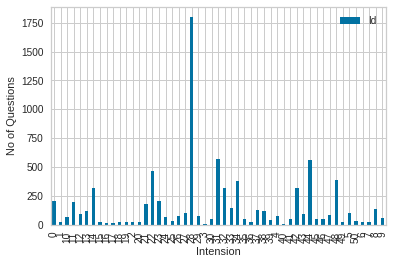

In [50]:
#graph for intension vs no of questions
df_output.plot.bar()
plt.xlabel('Intension')
plt.ylabel('No of Questions')
## 1.Intent number 28 has the highest number of questions.
## 2.Intent number 40 has lowest number of questions.

In [51]:
d = df.loc[df['Intension'] == '42']
d.head()

,Id,Intension
11,11,42
27,27,42
29,29,42
62,62,42
68,68,42


## 1. PREPROCESSING

### 1.1 Convert data into lowercase

In [52]:
#This avoids having multiple copies of the same words. 
#For example, while calculating the word count, ‘Analytics’ and ‘analytics’ will be taken as different words.
train_input['question'] = train_input['question'].apply(lambda x: " ".join(x.lower() for x in x.split()))
test_input['question'] = test_input['question'].apply(lambda x: " ".join(x.lower() for x in x.split()))
train_input.head()

,ID,question
0,0,"hello, i m was wrong forum for my question so ..."
1,1,is what the motilium relieve me against nausea?
2,2,my doctor prescribed adenyl. 2nd stamp of terr...
3,3,is there a form adapted to the child of 5 year...
4,4,my doctor treats me to a rhino pharingite and ...


### 1.2 Removing punctuations

In [53]:
#punctuations like ! ? @ #
train_input['question'] = train_input['question'].str.replace('[^\w\s]','')
test_input['question'] = test_input['question'].str.replace('[^\w\s]','')
train_input.head()

,ID,question
0,0,hello i m was wrong forum for my question so i...
1,1,is what the motilium relieve me against nausea
2,2,my doctor prescribed adenyl 2nd stamp of terri...
3,3,is there a form adapted to the child of 5 year...
4,4,my doctor treats me to a rhino pharingite and ...


### 1.3 Removing of stopwords 

In [54]:
#like i'm, a, about, above, after, again, against, all, am, an, and, any, are
from nltk.corpus import stopwords
stop = stopwords.words('english')
train_input['question'] = train_input['question'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
test_input['question'] = test_input['question'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
train_input.head()

,ID,question
0,0,hello wrong forum question based took first ti...
1,1,motilium relieve nausea
2,2,doctor prescribed adenyl 2nd stamp terrible he...
3,3,form adapted child 5 years micropakine
4,4,doctor treats rhino pharingite prescribed amox...


### 1.4 Lemmatization

In [55]:
from textblob import Word
train_input['question'] = train_input['question'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
test_input['question'] = test_input['question'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
train_input.head()

,ID,question
0,0,hello wrong forum question based took first ti...
1,1,motilium relieve nausea
2,2,doctor prescribed adenyl 2nd stamp terrible he...
3,3,form adapted child 5 year micropakine
4,4,doctor treat rhino pharingite prescribed amoxi...


### Saving preprocessed data into csv files

In [56]:
df11= pd.DataFrame(train_input)
df12 = pd.DataFrame(test_input)
df11.to_csv('trainaj.csv', index=False, encoding='utf8',sep=';')
df12.to_csv('testaj.csv',index=False, encoding='utf8',sep=';')

In [57]:
# Import data
b = pd.read_csv('./trainaj.csv', sep=";", index_col=0)
y2 = pd.read_csv('challenge_output_data_training_file_predict_the_expected_answer.csv', sep=";", index_col=0)
a = pd.read_csv('./testaj.csv',sep=";")

In [58]:
#Splitting the training dataset
X_train, X_test, y_train, y_test = train_test_split(b['question'], y2['intention'],
                                    test_size = 0.2, random_state=12)

In [59]:
count_vect = CountVectorizer()
X_q = count_vect.fit_transform(b['question'])

## 2 MODEL BUILDING

### 2.1 Stochastic gradient descent classifier

In [60]:
text_clf_svm = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                      ('tfidf', TfidfTransformer()),
                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=0.0001, n_iter=5, random_state=42))])

In [61]:
text_clf_svm.fit(X_train,y_train)
qw=text_clf_svm.predict(X_test)
text_clf_svm.fit(b['question'], y2['intention'])
predicted_svm = text_clf_svm.predict(a['question'])
print ("accuracy of SGD is : ",accuracy_score(qw, y_test))

/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy of SGD is :  0.6083437110834371


In [62]:
save=pd.DataFrame(predicted_svm)
save.to_csv('save.csv')
save.to_csv('save1.csv')
p5 = save.rename(columns={0:'intention'})
p5 = pd.concat((a['ID'],p5['intention']),axis=1,sort=False)
p5["ID;intention"] = p5["ID"].map(str)+";"+p5["intention"].map(str)
p5 = p5.drop(["ID","intention"],axis=1)
p5.to_csv("POSOS_SGD2.csv",index=False)
p5.head()

,ID;intention
0,8028;32
1,8029;32
2,8030;28
3,8031;28
4,8032;44


### Learning curve for SGD classifier

/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarnin

/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/divya/anaconda3/lib/python3.6/site-

/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6

/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/si

/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/lin

/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/divya/anaconda3/lib/python3.6/site-package

/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-package

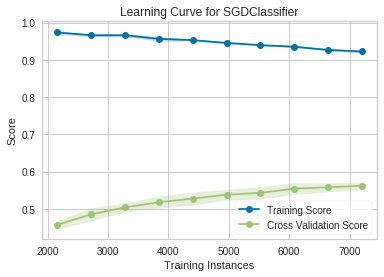

In [63]:
X = X_q
y = y2['intention']
# Create the learning curve visualizer
cv = StratifiedKFold(10)
sizes = np.linspace(0.3, 1.0, 10)
viz = LearningCurve(
    SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001, n_iter=5, random_state=42), cv=cv, train_sizes=sizes,
    scoring='f1_weighted', n_jobs=-1
)
# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

### 2.2 Random forest classifier

In [65]:
from sklearn.ensemble import RandomForestClassifier
text_clf_rf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                      ('tfidf', TfidfTransformer()),
                      ('clf-svm', RandomForestClassifier(n_estimators= 100, verbose =0, max_depth=None, min_samples_split=2, min_samples_leaf=1))])



clf = text_clf_rf.fit(X_train, y_train)

In [66]:
qw1 = text_clf_rf.predict(X_test)
print ("accuracy of RANDOM FOREST is : ",accuracy_score(qw1, y_test))

accuracy of RANDOM FOREST is :  0.5697384806973848


### Learning curve for Random forest classifier

/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python

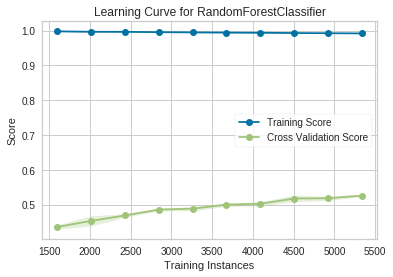

In [67]:
X = X_q
y = y2['intention']
# Create the learning curve visualizer
cv = StratifiedKFold(3)
sizes = np.linspace(0.3, 1.0, 10)
viz = LearningCurve(
    RandomForestClassifier(n_estimators= 100, verbose =0, max_depth=None, min_samples_split=2, min_samples_leaf=1), cv=cv, train_sizes=sizes,
    scoring='f1_weighted', n_jobs=-1
)
# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

### 2.3 Linear SVC

In [68]:
text_clf_lsv = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                      ('tfidf', TfidfTransformer()),
                      ('lsv', LinearSVC(penalty = 'l2', max_iter = 10000, loss='squared_hinge', dual=True, tol=0.00001, C=1, verbose = 1, multi_class='ovr')
)])
lsv = text_clf_lsv.fit(X_train, y_train)

[LibLinear]

In [69]:
qw3 = text_clf_lsv.predict(X_test)
print ("accuracy of linear svc is : ",accuracy_score(qw3, y_test))

accuracy of linear svc is :  0.6058530510585305


### Learning curve for linear SVC

/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python

/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python

/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-pack

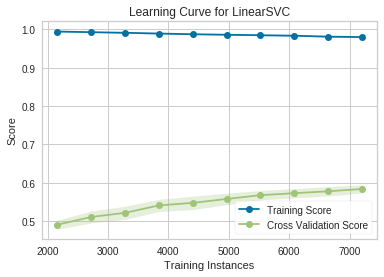

In [70]:
X = X_q
y = y2['intention']
# Create the learning curve visualizer
cv = StratifiedKFold(10)
sizes = np.linspace(0.3, 1.0, 10)
viz = LearningCurve(
   LinearSVC(penalty = 'l2', max_iter = 10000, loss='squared_hinge', dual=True, tol=0.00001, C=1, verbose = 1, multi_class='ovr') , cv=cv, train_sizes=sizes,
    scoring='f1_weighted', n_jobs=-1)
# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

### 2.4 Decision tree

In [71]:
text_clf_dt = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                      ('tfidf', TfidfTransformer()),
                      ('dt', ExtraTreesClassifier(n_estimators=100))])
dt = text_clf_dt.fit(X_train, y_train)

In [72]:
qw3 = text_clf_dt.predict(X_test)
print ("accuracy of decision tree is : ",accuracy_score(qw3, y_test))

accuracy of decision tree is :  0.5797011207970112


### Learning curve for Decision tree

/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/divya/anaconda3/lib/python

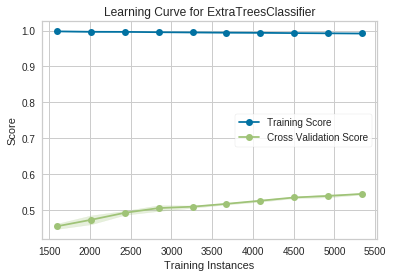

In [73]:
X = X_q
y = y2['intention']
# Create the learning curve visualizer
cv = StratifiedKFold(3)
sizes = np.linspace(0.3, 1.0, 10)
viz = LearningCurve(
   ExtraTreesClassifier(n_estimators=100) , cv=cv, train_sizes=sizes,
    scoring='f1_weighted', n_jobs=-1)
# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()